In [1]:
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
import re
import itertools as it
from Bio import motifs
from Bio import SeqIO
from Bio.Alphabet import IUPAC
from Bio.Seq import Seq
%matplotlib inline

In [342]:
# get ENCODE TF binding sites
tfbs = pd.read_table('c:/ravip/encode/wgEncodeRegTfbsClusteredV3.bed.gz',
                     header=None,names=['seqname','start','end','gene','V1','V2','V3','V4'],
                     dtype={'start':np.int, 'end':np.int})

In [613]:
dna = pd.read_table('d:/sequence/pancan/tcga505/mutations.tsv.gz', dtype={'chr': np.character})
dna_rnd = pd.read_table('d:/sequence/pancan/tcga505/randomised_TCGA505_toshare.txt.gz',
                        header=None,names=['barcode', 'cancer', 'chr', 'pos', 'ref_allele', 'var_allele'],
                        dtype={'chr': np.character}, skiprows=1)
dna['rnd'] = False
dna_rnd['rnd'] = True
dna_all = dna.append(dna_rnd)
dna_all['chr'] = ['chr' + x for x in dna_all['chr']]

CParserError: Error tokenizing data. C error: Calling read(nbytes) on source failed. Try engine='python'.

In [278]:
# get a set of TF binding matrices
h = open('pfm_vertebrates.txt')
jaspar = {m.name.strip().split(':')[0].upper(): m.counts.normalize().log_odds() for m in motifs.parse(h, 'jaspar')}
h.close()

In [344]:
# reduce tfbs to those for which we have matrices
print len(set(tfbs['gene'])), len(set(jaspar.keys())), len(set(tfbs['gene']).intersection(set(jaspar.keys())))
common = set(tfbs['gene']).intersection(set(jaspar.keys()))
tfbs2 = tfbs[tfbs['gene'].apply(lambda g: g in common)]

161 196 80


In [584]:
# get reference genome
hg19 = {contig.name: Seq(str(contig.seq), IUPAC.unambiguous_dna) for contig in SeqIO.parse('d:/sequence/genomes/hg19.fa', 'fasta')}

In [348]:
# left join by genomic regions
# limitations:
# genomic range columns (rcols1, rcols2) must be distinct
# only works if region sets are non-overlapping
# drops duplicates
def merge_regions(df1, cols1, df2, cols2):
    result = None
    [seqname1, start1, end1] = cols1[:3]
    [seqname2, start2, end2] = cols2[:3]
    cols1 = list(pd.Series(cols1).drop_duplicates())
    cols2 = list(pd.Series(cols2).drop_duplicates())
    for contig in set(df1[seqname1]).intersection(set(df2[seqname2])):
        c1 = df1[df1[seqname1]==contig].sort(end1).reset_index(drop=True)
        c2 = df2[df2[seqname2]==contig].sort(start2).drop_duplicates(start2).reset_index(drop=True)
        imerge = pd.cut(c1[end1], c2[start2], labels=False)
        keep = imerge >= 0
        cmerge = pd.concat([c1[cols1][keep], c2[cols2].iloc[imerge[keep]].reset_index(drop=True)], axis=1).reset_index(drop=True)
        cmerge = cmerge[cmerge[start1] <= cmerge[end2]]
        result = cmerge if result is None else pd.concat([result, cmerge])
    return result

In [520]:
# find TF binding regions matching mutations
mut_tf = merge_regions(dna_all, ['chr', 'pos', 'pos', 'ref_allele', 'var_allele', 'barcode', 'rnd'], tfbs2, ['seqname', 'start', 'end', 'gene'])

In [459]:
# score TF binding to mutation using TF matrix
def score_mut(m):
    mx = jaspar[m['gene']]
    n = len(mx[mx.keys()[0]])
    p = int(m['pos'])
    refseq = hg19[m['chr']][p-n-1:p+n]
    refscore = reduce(max, (score for pos, score in mx.search(refseq, threshold=0.5)), 0)
    mutseq = refseq[:n] + m['var_allele'] + refseq[n+1:]
    mutscore = reduce(max, (score for pos, score in mx.search(mutseq, threshold=0.5)), 0)
    return mutscore - refscore

In [521]:
# apply to all - takes ~10 minutes
mut_tf['delta'] = mut_tf.apply(score_mut, axis=1)

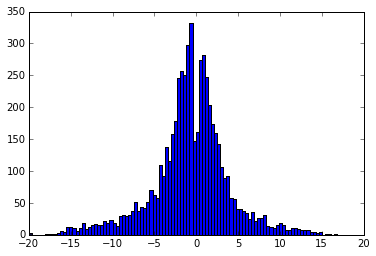

In [585]:
plt.hist(mut_tf['delta'][mut_tf['delta']!=0],100)
plt.show()

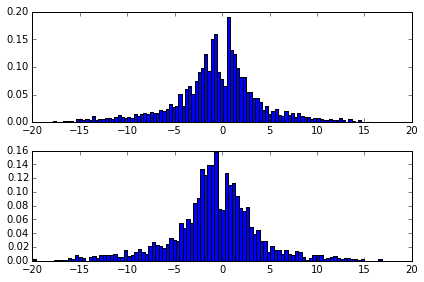

In [480]:
# compare rnd vs donor
fig, axes = plt.subplots(nrows=2)
ax0, ax1 = axes.flat
hdata = mut_tf[mut_tf['delta']!=0].reset_index(drop=True)
ax0.hist(hdata['delta'][hdata['rnd']], bins=100, normed=True)
ax1.hist(hdata['delta'][hdata['rnd']==False].reset_index(drop=True), bins=100, normed=True)
plt.tight_layout()
plt.show()

In [483]:
# get DHS-gene (enhancer-promoter) table
dhsgene = pd.read_table('c:/ravip/encode/allGeneCorrelations100000.p05.txt.gz')

In [589]:
# join mutation TF region (enhancer) with promoter & target gene
mut_tf_prom = merge_regions(mut_tf, ['seqname', 'start', 'end', 'gene', 'barcode', 'delta', 'rnd'],
                           dhsgene, ['dhs_chr', 'dhs_start', 'dhs_end', 'gene_name', 'cor'])

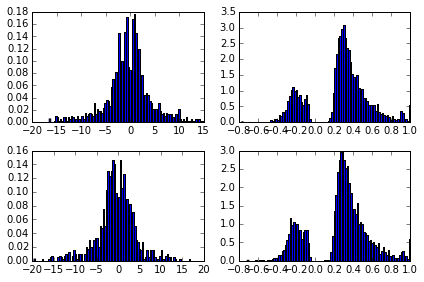

In [590]:
# plot distributions of delta and cor in rnd vs donor
# no significant difference
fig, axes = plt.subplots(nrows=2, ncols=2)
ax0, ax1, ax2, ax3 = axes.flat
hdata = mut_tf_prom[mut_tf_prom['delta'] != 0]
ax0.hist(hdata['delta'][hdata['rnd']], bins=100, normed=True)
ax2.hist(hdata['delta'][hdata['rnd']==False].reset_index(drop=True), bins=100, normed=True)
ax1.hist(mut_tf_prom['cor'][mut_tf_prom['rnd']].reset_index(drop=True), bins=100, normed=True)
ax3.hist(mut_tf_prom['cor'][mut_tf_prom['rnd']==False].reset_index(drop=True), bins=100, normed=True)
plt.tight_layout()
plt.show()

In [500]:
print len(set(mut_tf_prom['gene_name'][mut_tf_prom['delta'].abs()>5])), len(set(mut_tf_prom['gene_name']))

418 8838


In [605]:
# aggregate by donor, gene
x = mut_tf_prom[['gene_name', 'delta', 'rnd', 'barcode']]
x = x.groupby(['gene_name', 'rnd', 'barcode'])
x = x.aggregate(np.mean)
x = x.reset_index()
x = x.groupby(['gene_name', 'rnd'])
x = x.aggregate({'delta': [np.min, np.mean, np.std, np.max, len]})
x = x.unstack()
x = x.fillna(0)
mut_tf_byprom = x
x

delta                                                    \
                  amin                mean                 std             
rnd              False     True      False     True      False     True    
gene_name                                                                  
5S_rRNA       0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
7SK          -0.142765 -0.462739 -0.003560 -0.110055  0.137912  0.172308   
A1CF          0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
A4GALT        0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
AACSP1        0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
AADACL2       0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
AADACL3       0.000000 -4.454228  0.000000 -2.227114  0.000000  3.149615   
AADAT         0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
AAGAB         0.000000  0.000000  0.000000  0.866651  0.000000  1.017360   
AARS2         0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
AASDH         0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
AB019438.63   0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
ABCA1         0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
ABCB10        0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
ABCB9         0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
ABCC10       -0.028578  0.000000 -0.028578  0.000000  0.000000  0.000000   
ABCC2         0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
ABCC4         0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
ABCC5         0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
ABCC5-AS1     0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
ABCC9         0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
ABCD4         0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
ABCE1         0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
ABCG2         0.000000 -4.852145  0.000000 -2.426072  0.000000  3.430984   
ABHD10        0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
ABHD14A-ACY1  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
ABHD14B       0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
ABHD2         0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
ABHD5         0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
ABHD6         0.000000 -3.779486  0.000000 -1.889743  0.000000  2.672500   
...                ...       ...       ...       ...       ...       ...   
ZNF711        0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
ZNF717        0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
ZNF750        0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
ZNF770        0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
ZNF774        0.000000 -0.676145  0.000000 -0.338073  0.000000  0.478107   
ZNF780B       0.000000 -9.665963  0.000000 -9.665963  0.000000  0.000000   
ZNF790        0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
ZNF80         0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
ZNF827        0.000000 -1.108017  0.000000 -0.554009  0.000000  0.783486   
ZNF839        0.000000 -0.014572  0.000000 -0.004857  0.000000  0.008413   
ZNF843        0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
ZNF852        0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
ZNF860        0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
ZNF876P       0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
ZNRF1         0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
ZNRF3         0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
ZP3           0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
ZP4           0.000000  0.000000  0.000000  0.000000  0.000000  0

In [606]:
mut_tf_byprom['lendiff'] = mut_tf_byprom['delta']['len'][False] - mut_tf_byprom['delta']['len'][True]
mut_tf_byprom['meandiff'] = mut_tf_byprom['delta']['mean'][False] - mut_tf_byprom['delta']['mean'][True]
mut_tf_byprom['totlen'] = mut_tf_byprom['delta']['len'][False] + mut_tf_byprom['delta']['len'][True]

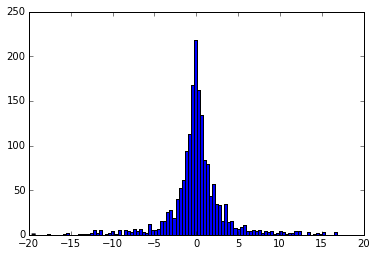

In [608]:
# GO shows no interesting terms for large meandiff
mut_tf_byprom[mut_tf_byprom['meandiff'].abs()>5].to_csv('mut_tf_byprom.txt')
# plot is just normal
plt.hist(mut_tf_byprom['meandiff'][mut_tf_byprom['meandiff']!=0],100)
plt.show()